<a href="https://colab.research.google.com/github/MalakSwar/AI_Project/blob/main/AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Importing the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score



df = pd.read_csv('https://raw.githubusercontent.com/MalakSwar/AI_Project/refs/heads/main/Churn_Dataset.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#2) Data Analysis

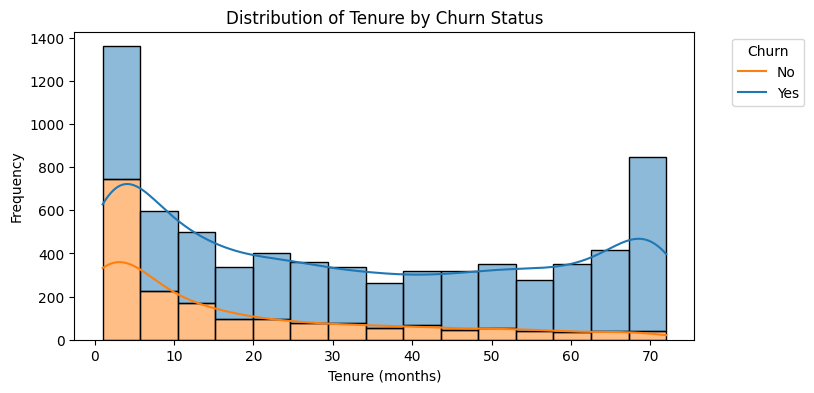

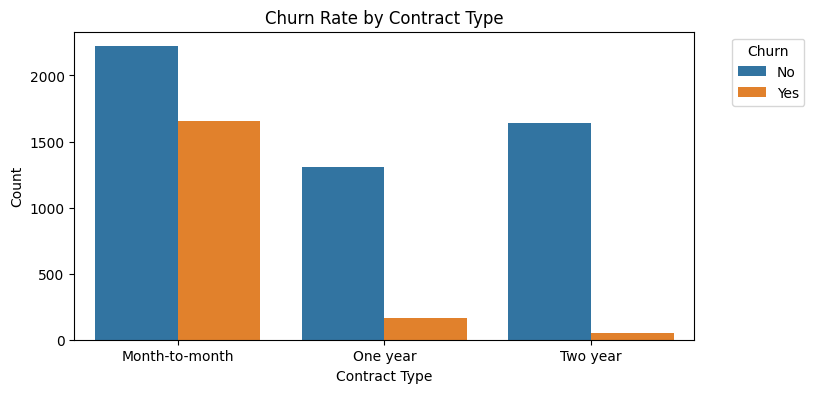

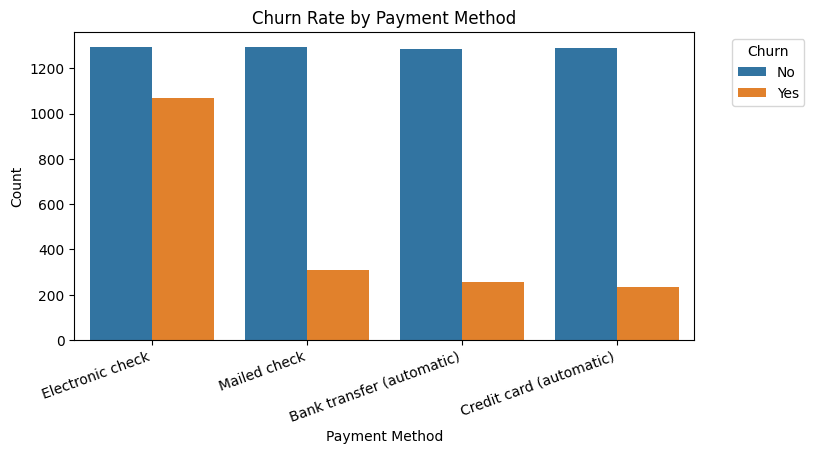

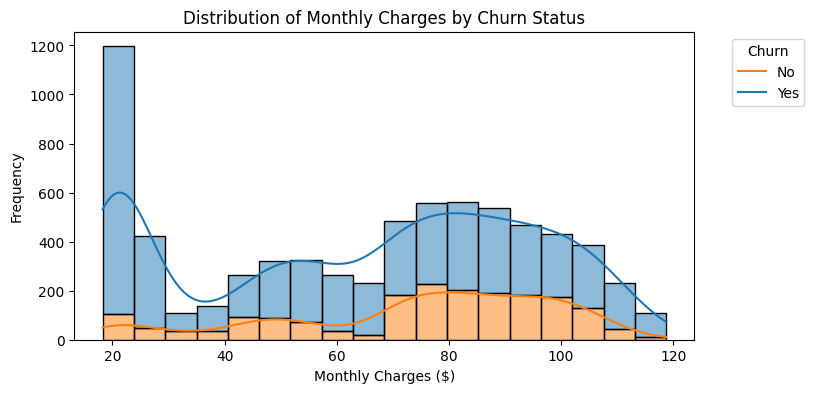

Correlation with Churn:
 tenure           -0.354049
MonthlyCharges    0.192858
Churn             1.000000
Name: Churn, dtype: float64


In [2]:
df = df[(df['TotalCharges'] != ' ') & (df['TotalCharges'] != '')].copy()
df.loc[:, 'TotalCharges'] = df['TotalCharges'].astype(float)
df.loc[:, 'Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Churn_Label'] = df['Churn'].apply(lambda x: 'Yes' if x == 1 else 'No')

plt.figure(figsize=(8, 4))
plot1 = sns.histplot(data=df, x='tenure', hue='Churn_Label', kde=True, multiple="stack")
plt.title("Distribution of Tenure by Churn Status")
plt.xlabel("Tenure (months)")
plt.ylabel("Frequency")
plot1.legend(title='Churn', bbox_to_anchor=(1.05, 1), loc='upper left', labels=['No', 'Yes'])
plt.show()

plt.figure(figsize=(8, 4))
plot2 = sns.countplot(x='Contract', data=df, hue='Churn_Label')
plt.title("Churn Rate by Contract Type")
plt.xlabel("Contract Type")
plt.ylabel("Count")
plot2.legend(title='Churn', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(8, 4))
plot3 = sns.countplot(x='PaymentMethod', data=df, hue='Churn_Label')
plt.title("Churn Rate by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Count")
plt.xticks(rotation=20, ha='right')
plot3.legend(title='Churn', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(8, 4))
plot4 = sns.histplot(data=df, x='MonthlyCharges', hue='Churn_Label', kde=True, multiple="stack")
plt.title("Distribution of Monthly Charges by Churn Status")
plt.xlabel("Monthly Charges ($)")
plt.ylabel("Frequency")
plot4.legend(title='Churn', bbox_to_anchor=(1.05, 1), loc='upper left', labels=['No', 'Yes'])
plt.show()

correlations = df[['tenure', 'MonthlyCharges', 'Churn']].corr()
print("Correlation with Churn:\n", correlations['Churn'])

contract_mapping = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
df.loc[:, 'Contract'] = df['Contract'].map(contract_mapping)
payment_mapping = {'Electronic check': 0, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3}
df.loc[:, 'PaymentMethod'] = df['PaymentMethod'].map(payment_mapping)

#Catigorising Tenure Column

In [3]:
def tenure_state(tenure):
    if tenure <= 12:
        return 'Low'
    elif 12 < tenure <= 36:
        return 'Medium'
    else:
        return 'High'

df['Tenure'] = df['tenure'].apply(tenure_state)

#Applying Markov Model

In [6]:
X = df[['Tenure', 'Contract', 'PaymentMethod']]
y = df['Churn']

train_df, test_df, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

hmm_model = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: {"Churn": defaultdict(int), "No Churn": defaultdict(int)})))
transition_counts = defaultdict(lambda: defaultdict(int))

for i in range(1, len(train_df)):
    prev_row = train_df.iloc[i - 1]
    curr_row = train_df.iloc[i]
    prev_state = (prev_row['Tenure'], prev_row['Contract'], prev_row['PaymentMethod'])
    curr_state = (curr_row['Tenure'], curr_row['Contract'], curr_row['PaymentMethod'])
    churn = y_train.iloc[i]
    transition_counts[prev_state][curr_state] += 1
    hmm_model[prev_row['Tenure']][prev_row['Contract']][prev_row['PaymentMethod']]["Churn"][churn] += 1

for tenure in hmm_model:
    for contract in hmm_model[tenure]:
        for payment_method in hmm_model[tenure][contract]:
            churn_data = hmm_model[tenure][contract][payment_method]["Churn"]
            total = sum(churn_data.values()) + 2
            for churn_state in churn_data:
                churn_data[churn_state] = (churn_data[churn_state] + 1) / total

transition_probs = defaultdict(lambda: defaultdict(float))
for prev_state, next_states in transition_counts.items():
    total_transitions = sum(next_states.values())
    for next_state, count in next_states.items():
        transition_probs[prev_state][next_state] = count / total_transitions

# Printing the Transition Probabilities
#print("Transition Probabilities:")
#for prev_state, next_states in transition_probs.items():
#    print(f"Previous State: {prev_state}")
#    for next_state, prob in next_states.items():
#        print(f"   Next State: {next_state} -> Probability: {prob:.2%}")

reverse_contract_mapping = {v: k for k, v in contract_mapping.items()}
reverse_payment_mapping = {v: k for k, v in payment_mapping.items()}


print("Emission Probabilities (Churn):")
prev_tenure = None
for tenure in hmm_model:
    if prev_tenure and tenure != prev_tenure:
        print()
    prev_tenure = tenure

    for contract in hmm_model[tenure]:
        for payment_method in hmm_model[tenure][contract]:
            decoded_contract = reverse_contract_mapping.get(contract, "Unknown")
            decoded_payment_method = reverse_payment_mapping.get(payment_method, "Unknown")

            churn_probs = hmm_model[tenure][contract][payment_method]["Churn"]
            print("{"f"Tenure: {tenure}, Contract: {decoded_contract}, Payment Method: {decoded_payment_method}""}:")
            print(f"   Churn Probability: {churn_probs[1]:.2%}", f"\n   No Churn Probability: {churn_probs[0]:.2%}")

Emission Probabilities (Churn):
{Tenure: Low, Contract: Month-to-month, Payment Method: Electronic check}:
   Churn Probability: 26.27% 
   No Churn Probability: 73.73%
{Tenure: Low, Contract: Month-to-month, Payment Method: Mailed check}:
   Churn Probability: 25.75% 
   No Churn Probability: 74.25%
{Tenure: Low, Contract: Month-to-month, Payment Method: Credit card (automatic)}:
   Churn Probability: 26.49% 
   No Churn Probability: 73.51%
{Tenure: Low, Contract: Month-to-month, Payment Method: Bank transfer (automatic)}:
   Churn Probability: 28.25% 
   No Churn Probability: 71.75%
{Tenure: Low, Contract: One year, Payment Method: Bank transfer (automatic)}:
   Churn Probability: 33.33% 
   No Churn Probability: 66.67%
{Tenure: Low, Contract: One year, Payment Method: Mailed check}:
   Churn Probability: 23.64% 
   No Churn Probability: 76.36%
{Tenure: Low, Contract: One year, Payment Method: Electronic check}:
   Churn Probability: 21.05% 
   No Churn Probability: 78.95%
{Tenure: L

#Model Evaluation


In [5]:
y_true = []
y_pred = []
threshold = 0.3

for i in range(len(test_df)):
    curr_row = test_df.iloc[i]
    curr_state = (curr_row['Tenure'], curr_row['Contract'], curr_row['PaymentMethod'])
    y_true.append(y_test.iloc[i])
    churn_probs = hmm_model.get(curr_row['Tenure'], {}).get(curr_row['Contract'], {}).get(curr_row['PaymentMethod'], {}).get("Churn", {})
    if 1 in churn_probs:
        churn_prob = churn_probs[1]
    else:
        churn_prob = 0.5
    y_pred.append(1 if churn_prob >= threshold else 0)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)

print("Model Evaluation on Test Data")
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")

Model Evaluation on Test Data
Accuracy: 65.25%
Precision: 24.04%
Recall: 13.12%
